In [1]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import torch
from tqdm import tqdm

warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid")

DEVICE = torch.device("cuda:0")

In [2]:
def nb_cdf(x, mu, r):
    """
    Compute CDF of NegativeBinomial(mu, r) at value x.
    The distribution is parameterized by mean 'mu' and 'r' (number of failures).
    P(X=k) = C(k+r-1, k) * p^r * (1-p)^k, where p = r / (mu+r).
    X is the number of successes given r failures.

    x: integer value(s) to evaluate CDF at (can be scalar or tensor).
    mu: mean of the Negative Binomial distribution (mu > 0). Can be scalar or tensor.
    r: number of failures (dispersion parameter, r > 0). Can be scalar or tensor.
    """
    # Ensure inputs are tensors and determine their data type and device
    # We'll use float for calculations and then convert x to int for indexing.
    if not isinstance(x, torch.Tensor):
        # Try to infer dtype and device from mu or r if they are tensors
        if isinstance(mu, torch.Tensor):
            dtype = mu.dtype
        elif isinstance(r, torch.Tensor):
            dtype = r.dtype
        else: # All scalars
            dtype = torch.float32
        x = torch.as_tensor(x, dtype=dtype, device=DEVICE)
    else:
        dtype = x.dtype

    x = torch.as_tensor(x, dtype=torch.float32, device=DEVICE).squeeze()
    mu = torch.as_tensor(mu, dtype=torch.float32, device=DEVICE).squeeze()
    r = torch.as_tensor(r, dtype=torch.float32, device=DEVICE).squeeze()

    if torch.any(mu < 0):
        raise ValueError("mu (mean) must be non-negative.")
    if torch.any(r <= 0):
        raise ValueError("r (number of failures) must be positive.")


    # Initialize result tensor with zeros (CDF for x < 0 is 0)
    result = torch.zeros_like(x, dtype=dtype)

    # Floor x values (as CDF is for discrete distributions)
    x_floor = torch.floor(x)

    # Identify non-negative x values for which CDF needs to be computed
    # CDF for x < 0 is 0, already handled by initialization.
    # CDF for mu = 0: P(X=0)=1, P(X>0)=0. So CDF is 1 for x >= 0.
    
    # Mask for elements that need actual PMF summation
    # These are x >= 0 AND mu > 0
    compute_mask = (x_floor >= 0) & (mu > 0)
    
    # Handle mu = 0 case separately: CDF is 1 for x >= 0
    mu_zero_mask = (x_floor >= 0) & (mu == 0)
    result[mu_zero_mask] = 1.0
    
    # r_bad_ix = torch.where(torch.isnan(r) | torch.isinf(r))
    # print(r_bad_ix)
    # mu_bad_ix = torch.where(torch.isnan(mu) | torch.isinf(mu))
    # print(mu_bad_ix)
    if not torch.any(compute_mask): # No elements need full computation
        return result

    # --- Prepare for PMF calculation for elements in compute_mask ---
    # Flatten the tensors for processing, selecting only elements in compute_mask
    x_proc = x_floor[compute_mask].to(torch.int64) # Convert to int64 for indexing
    mu_proc = mu[compute_mask] # Shape: (N_selected,)
    r_proc = r[compute_mask]   # Shape: (N_selected,)

    # Determine max k needed for PMF calculations
    max_k = x_proc.max().item()
    # ks: tensor of [0, 1, ..., max_k]
    ks = torch.arange(0, max_k + 1, device=DEVICE).view(1, -1) # Shape: (1, max_k+1)

    # Reshape mu_proc and r_proc to (N_selected, 1) for broadcasting with ks
    mu_proc = mu_proc.view(-1, 1)
    r_proc = r_proc.view(-1, 1)

    # --- Parameter conversion and PMF calculation (in log-space) ---
    # p = r / (mu + r)
    # 1-p = mu / (mu + r)
    # Add small epsilon for numerical stability with log, especially if mu or r are near zero
    # (though mu_proc > 0 is guaranteed here, r_proc > 0 by input validation)
    eps = torch.finfo(dtype).eps

    # log(p) = log(r) - log(mu+r)
    log_p_val = torch.log(r_proc + eps) - torch.log(mu_proc + r_proc + eps)
    bad_ix = torch.where(torch.isnan(log_p_val))
    log_p_val[bad_ix] = 0  # TODO: ??????????????????????????????????????????????????
    # log(1-p) = log(mu) - log(mu+r)
    log_1_minus_p_val = torch.log(mu_proc + eps) - torch.log(mu_proc + r_proc + eps)
    # print(x_proc.shape, mu_proc.shape, r_proc.shape, ks.shape, log_p_val.shape, log_1_minus_p_val.shape)

    # Log PMF: lgamma(k+r) - lgamma(k+1) - lgamma(r) + r*log(p) + k*log(1-p)
    # ks: (1, max_k+1)
    # r_proc, log_p_val, log_1_minus_p_val: (N_selected, 1)
    # All lgamma terms will broadcast correctly.
    try:
        log_pmf_table = torch.distributions.NegativeBinomial(total_count=r_proc, logits=log_p_val).log_prob(ks)
    except:
        nan_ix = torch.where(torch.isnan(log_p_val))
        inf_ix = torch.where(torch.isinf(log_p_val))
        print("nan idx", nan_ix)
        print("inf idx", inf_ix)
        print("log_p_val", log_p_val[nan_ix])
        print("mu_proc", mu_proc[nan_ix])
        print("r_proc", r_proc[nan_ix])
        print("mu", mu[nan_ix[0]])
        print("r", r[nan_ix[0]])
        1/0
    # log_pmf_table = (torch.lgamma(ks + r_proc) -       # Shape: (N_selected, max_k+1)
    #                  torch.lgamma(ks + 1) -            # Shape: (1, max_k+1), broadcasts
    #                  torch.lgamma(r_proc) +            # Shape: (N_selected, 1), broadcasts
    #                  r_proc * log_p_val +              # Shape: (N_selected, 1), broadcasts
    #                  ks * log_1_minus_p_val)           # Shape: (N_selected, max_k+1)

    pmf_table = torch.exp(log_pmf_table) # Shape: (N_selected, max_k+1)

    # Cumulative sum to get CDF table
    cdf_table = torch.cumsum(pmf_table, dim=1) # Shape: (N_selected, max_k+1)

    # Gather the CDF values corresponding to each x_proc
    # Create row indices for gathering: [0, 1, ..., N_selected-1]
    idx_rows = torch.arange(len(x_proc), device=DEVICE)
    # x_proc contains column indices
    cdf_values_for_proc = cdf_table[idx_rows, x_proc]

    # Place these computed CDF values into the correct positions in the result tensor
    result[compute_mask] = cdf_values_for_proc
    
    return result

In [3]:
def run_analysis(data_dir):
    def load_val_data(epoch):
        val_mu_tech_r1 = np.load(data_dir / f'val_mu_tech_val_r1_{epoch}.npy')
        val_mu_tech_r2 = np.load(data_dir / f'val_mu_tech_val_r2_{epoch}.npy')
        val_mu1_r1_diff = np.load(data_dir / f'val_mu1_r1_diff_{epoch}.npy')
        val_mu1_r2_diff = np.load(data_dir / f'val_mu2_r2_diff_scaled_{epoch}.npy')
        val_yi_r1 = np.load(data_dir / f'val_y_i_val_r1_{epoch}.npy')
        val_yi_r2 = np.load(data_dir / f'val_y_i_val_r2_{epoch}.npy')
        try:
            val_r_r1 = np.load(data_dir / f'val_r1_tech_val_r1_{epoch}.npy')
            val_r_r2 = np.load(data_dir / f'val_r2_tech_val_r2_{epoch}.npy')
        except FileNotFoundError:
            val_r_r1 = None
            val_r_r2 = None
        try:
            val_xi_r1 = np.load(data_dir / 'val_xi_val_r1.npy')
            val_xi_r1 = pd.DataFrame(val_xi_r1)
            val_xi_r1.columns = ["ctrl_reads_r1", "ctrl_mapq_r1", "ctrl_sd_r1", "exp_mapq_r1", "exp_sd_r1"]
            val_xi_r2 = pd.DataFrame(np.load(data_dir / 'val_xi_val_r2.npy'))
            val_xi_r2.columns = ["ctrl_reads_r2", "ctrl_mapq_r2", "ctrl_sd_r2", "exp_mapq_r2", "exp_sd_r2"]
            x_vals = pd.concat([val_xi_r1, val_xi_r2], axis=1)
        except FileNotFoundError:
            x_vals = None


        df = pd.DataFrame({ 
            'mu_tech_r1': val_mu_tech_r1,
            'mu_tech_r2': val_mu_tech_r2,
            'mu1_r1_diff': val_mu1_r1_diff,
            'mu2_r2_diff': val_mu1_r2_diff,
            'yi_r1': val_yi_r1,
            'yi_r2': val_yi_r2,
            'r_r1': val_r_r1,
            'r_r2': val_r_r2,
        })
        if x_vals is not None:
            df = pd.concat([df, x_vals], axis=1)

        device = torch.device("cuda:0")
        r1_quantiles = []
        r2_quantiles = []
        for i in np.arange(0, len(df), 100_000):
            stop = min(i + 100_000, len(df))
            r1_quantiles += nb_cdf(
                torch.tensor([df["yi_r1"].values[i:stop].flatten()]).to(device),
                torch.tensor([df["mu_tech_r1"].values[i:stop].flatten()]).to(device),
                torch.tensor([df["r_r1"].values[i:stop].flatten()]).to(device)
                ).cpu().numpy().flatten().tolist()
            r2_quantiles += nb_cdf(
                torch.tensor([df["yi_r2"].values[i:stop].flatten()]).to(device),
                torch.tensor([df["mu_tech_r2"].values[i:stop].flatten()]).to(device),
                torch.tensor([df["r_r2"].values[i:stop].flatten()]).to(device)
                ).cpu().numpy().flatten().tolist()

        df["quantile_r1"] = r1_quantiles
        df["quantile_r2"] = r2_quantiles

        return df

    epoch_dfs = []
    for i in tqdm(range(100)):
        try:
            epoch_dfs.append(load_val_data(i))
        except FileNotFoundError:
            break

    fig, axes = plt.subplots(5, 2, figsize=(20, 25))

    # biol_corrs = [np.corrcoef(df["res_1"], df["res_2"])[0][1] for df in epoch_dfs]
    # raw_corrs = [np.corrcoef(df["y_1"], df["y_2"])[0][1] for df in epoch_dfs]

    pearson_corrs = []
    spearman_corrs = [] 

    for epoch_idx, epoch_df in tqdm(enumerate(epoch_dfs)):
        for r1_sd, r1_sd_df in epoch_df.groupby("exp_sd_r1"):
            r2_sds = r1_sd_df["exp_sd_r2"].unique()
            if len(r2_sds) > 1:
                raise ValueError
            pearson_corrs.append({
                "(raw1, raw2)": np.corrcoef(r1_sd_df["yi_r1"], r1_sd_df["yi_r2"])[0][1],
                "(res1, res2)": np.corrcoef(r1_sd_df["mu1_r1_diff"], r1_sd_df["mu2_r2_diff"])[0][1],
                "(quant1, quant2)": np.corrcoef(r1_sd_df["quantile_r1"], r1_sd_df["quantile_r2"])[0][1],
                "(quant1, raw1)": np.corrcoef(r1_sd_df["quantile_r1"], r1_sd_df["yi_r1"])[0][1],
                "(quant2, raw2)": np.corrcoef(r1_sd_df["quantile_r2"], r1_sd_df["yi_r2"])[0][1],
                "epoch": epoch_idx,
            })

            spearman_corrs.append({
                "(raw1, raw2)": stats.spearmanr(r1_sd_df["yi_r1"], r1_sd_df["yi_r2"])[0],
                "(res1, res2)": stats.spearmanr(r1_sd_df["mu1_r1_diff"], r1_sd_df["mu2_r2_diff"])[0],
                "(quant1, quant2)": stats.spearmanr(r1_sd_df["quantile_r1"], r1_sd_df["quantile_r2"])[0],
                "(quant1, raw1)": stats.spearmanr(r1_sd_df["quantile_r1"], r1_sd_df["yi_r1"])[0],
                "(quant2, raw2)": stats.spearmanr(r1_sd_df["quantile_r2"], r1_sd_df["yi_r2"])[0],
                "epoch": epoch_idx,
            })

    epoch_pearson_corrs = pd.DataFrame(pearson_corrs)
    epoch_spearman_corrs = pd.DataFrame(spearman_corrs)
    for col_ix, col in enumerate(["(raw1, raw2)", "(res1, res2)", "(quant1, quant2)", "(quant1, raw1)", "(quant2, raw2)"]):
    # for col_ix, col in enumerate(["(raw1, raw2)", "(res1, res2)"]):
        sns.boxplot(
            data=epoch_pearson_corrs,
            x="epoch",
            y=col,
            ax=axes[col_ix, 0],
        )
        axes[col_ix, 0].set_title(f"Pearson {col}")
        sns.boxplot(
            data=epoch_spearman_corrs,
            x="epoch",
            y=col,
            ax=axes[col_ix, 1],
        )
        axes[col_ix, 1].set_title(f"Spearman {col}")

    return epoch_dfs

# Visualize

 55%|█████▌    | 55/100 [05:34<04:33,  6.08s/it]
55it [05:50,  6.37s/it]


,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2,r_r1,r_r2,ctrl_reads_r1,ctrl_mapq_r1,ctrl_sd_r1,exp_mapq_r1,exp_sd_r1,ctrl_reads_r2,ctrl_mapq_r2,ctrl_sd_r2,exp_mapq_r2,exp_sd_r2,quantile_r1,quantile_r2
0,3.548480,2.245735,-2.548480,-4.177568,1.0,0.0,61.190895,38.226662,0.0,1.000000,2.975306,0.999000,2.710890,0.0,1.000000,2.975306,1.000000,1.860223,6.394167e-17,9.114523e-12
1,3.548480,2.245735,-1.548480,-4.177568,2.0,0.0,61.190895,38.226662,0.0,1.000000,2.975306,0.999000,2.710890,0.0,1.000000,2.975306,1.000000,1.860223,9.986506e-16,9.114523e-12
2,3.548480,2.245735,-1.548480,-4.177568,2.0,0.0,61.190895,38.226662,0.0,1.000000,2.975306,0.999000,2.710890,0.0,1.000000,2.975306,1.000000,1.860223,9.986506e-16,9.114523e-12
3,3.548480,2.245735,-1.548480,-4.177568,2.0,0.0,61.190895,38.226662,0.0,1.000000,2.975306,0.999000,2.710890,0.0,1.000000,2.975306,1.000000,1.860223,9.986506e-16,9.114523e-12
4,3.548480,2.245735,-2.548480,-4.177568,1.0,0.0,61.190895,38.226662,0.0,1.000000,2.975306,0.999000,2.710890,0.0,1.000000,2.975306,1.000000,1.860223,6.394167e-17,9.114523e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364027,2.170241,1.592408,-1.170241,-1.964714,1.0,0.0,30.074652,21.397181,0.0,1.000000,2.591536,0.999000,1.842645,0.0,1.000000,2.591536,1.000000,1.233800,3.841080e-08,7.697464e-07
8364028,2.259549,1.651711,-1.259549,-2.037881,1.0,0.0,63.087772,45.233894,2.0,0.999937,2.591536,0.999937,1.842645,2.0,0.999937,2.591536,1.000000,1.233800,9.806563e-18,5.399490e-14
8364029,2.352775,1.714295,-1.352775,-0.881298,1.0,1.0,129.649261,93.694679,4.0,0.999937,2.591536,0.999937,1.842645,4.0,0.999937,2.591536,0.999937,1.233800,1.950907e-37,6.890998e-27
8364030,2.352775,1.714295,-1.352775,1.586303,1.0,3.0,129.649261,93.694679,4.0,0.999937,2.591536,0.999937,1.842645,4.0,0.999937,2.591536,0.999937,1.233800,1.950907e-37,2.666357e-24


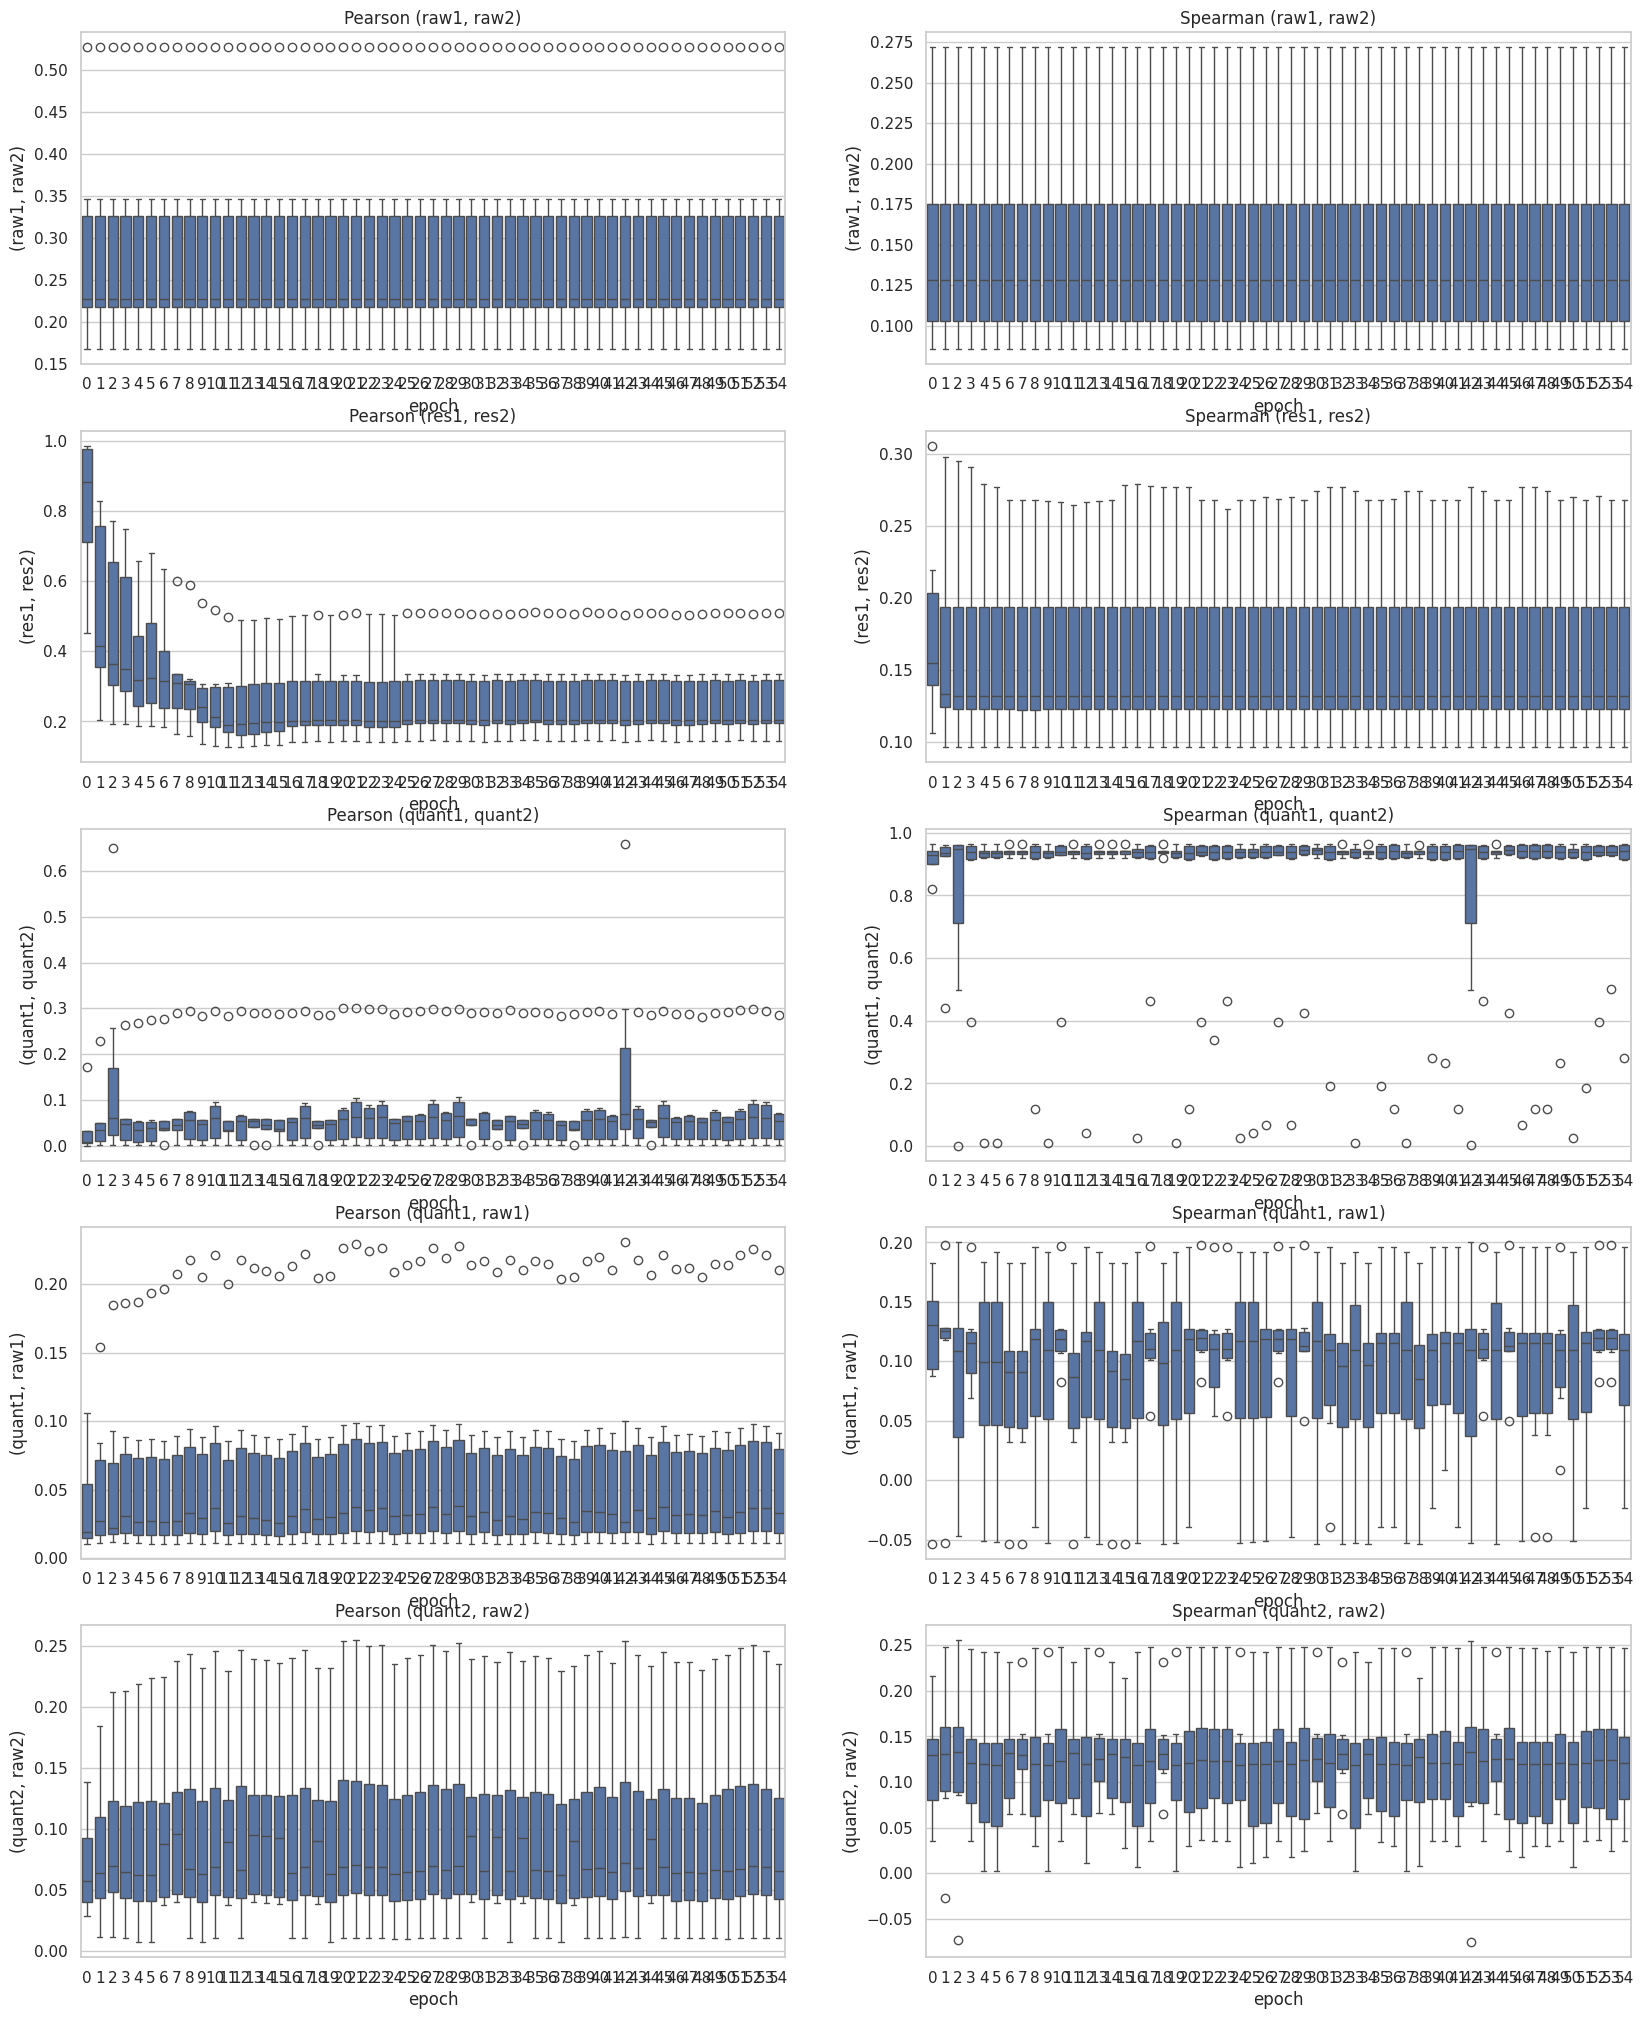

In [4]:
h3k27me3_all_3_full_small = run_analysis(Path("/lotterlab/users/abdul/repos/chipvi/runs/mu_r_ll_only/h3k27me3"))
h3k27me3_all_3_full_small[-1]

 45%|████▌     | 45/100 [05:43<07:00,  7.64s/it]
45it [05:19,  7.10s/it]


,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2,r_r1,r_r2,ctrl_reads_r1,ctrl_mapq_r1,ctrl_sd_r1,exp_mapq_r1,exp_sd_r1,ctrl_reads_r2,ctrl_mapq_r2,ctrl_sd_r2,exp_mapq_r2,exp_sd_r2,quantile_r1,quantile_r2
0,2.334078,2.213119,-0.334078,-5.434768,2.0,0.0,2.603615,3.735073,1.0,0.999000,2.493534,0.999000,2.608079,0.0,1.000000,2.898569,1.000000,2.455705,0.816073,0.162002
1,2.334078,2.213119,-0.334078,-5.434768,2.0,0.0,2.603615,3.735073,1.0,0.999000,2.493534,0.999000,2.608079,0.0,1.000000,2.898569,1.000000,2.455705,0.816073,0.162002
2,2.235290,2.213119,-0.235290,-5.434768,2.0,0.0,2.937718,3.735073,0.0,1.000000,2.493534,0.999000,2.608079,0.0,1.000000,2.898569,1.000000,2.455705,0.753185,0.162002
3,2.235290,2.213119,-0.235290,-5.434768,2.0,0.0,2.937718,3.735073,0.0,1.000000,2.493534,0.999000,2.608079,0.0,1.000000,2.898569,1.000000,2.455705,0.753185,0.162002
4,2.334078,2.213119,-1.334078,-5.434768,1.0,0.0,2.603615,3.735073,1.0,0.999000,2.493534,0.999000,2.608079,0.0,1.000000,2.898569,1.000000,2.455705,0.630429,0.162002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8773627,2.305862,1.998290,-0.305862,-1.790909,2.0,1.0,3.362928,2.418835,0.0,1.000000,2.758586,0.999937,2.629396,3.0,0.999926,2.591536,0.999937,1.793976,0.682649,0.645348
8773628,2.399470,1.900768,0.600530,-1.615956,3.0,1.0,2.984857,2.807362,1.0,0.999937,2.758586,0.999937,2.629396,2.0,0.999923,2.591536,0.999937,1.793976,0.876395,0.551153
8773629,2.399470,1.998291,1.600530,-3.584885,4.0,0.0,2.984857,2.418856,1.0,0.999937,2.758586,0.999937,2.629396,3.0,0.999921,2.591536,1.000000,1.793976,0.940522,0.347727
8773630,2.517912,1.900769,0.482088,-3.409933,3.0,0.0,2.593631,2.807387,2.0,0.999937,2.758586,0.999937,2.629396,2.0,0.999921,2.591536,1.000000,1.793976,0.922090,0.269025


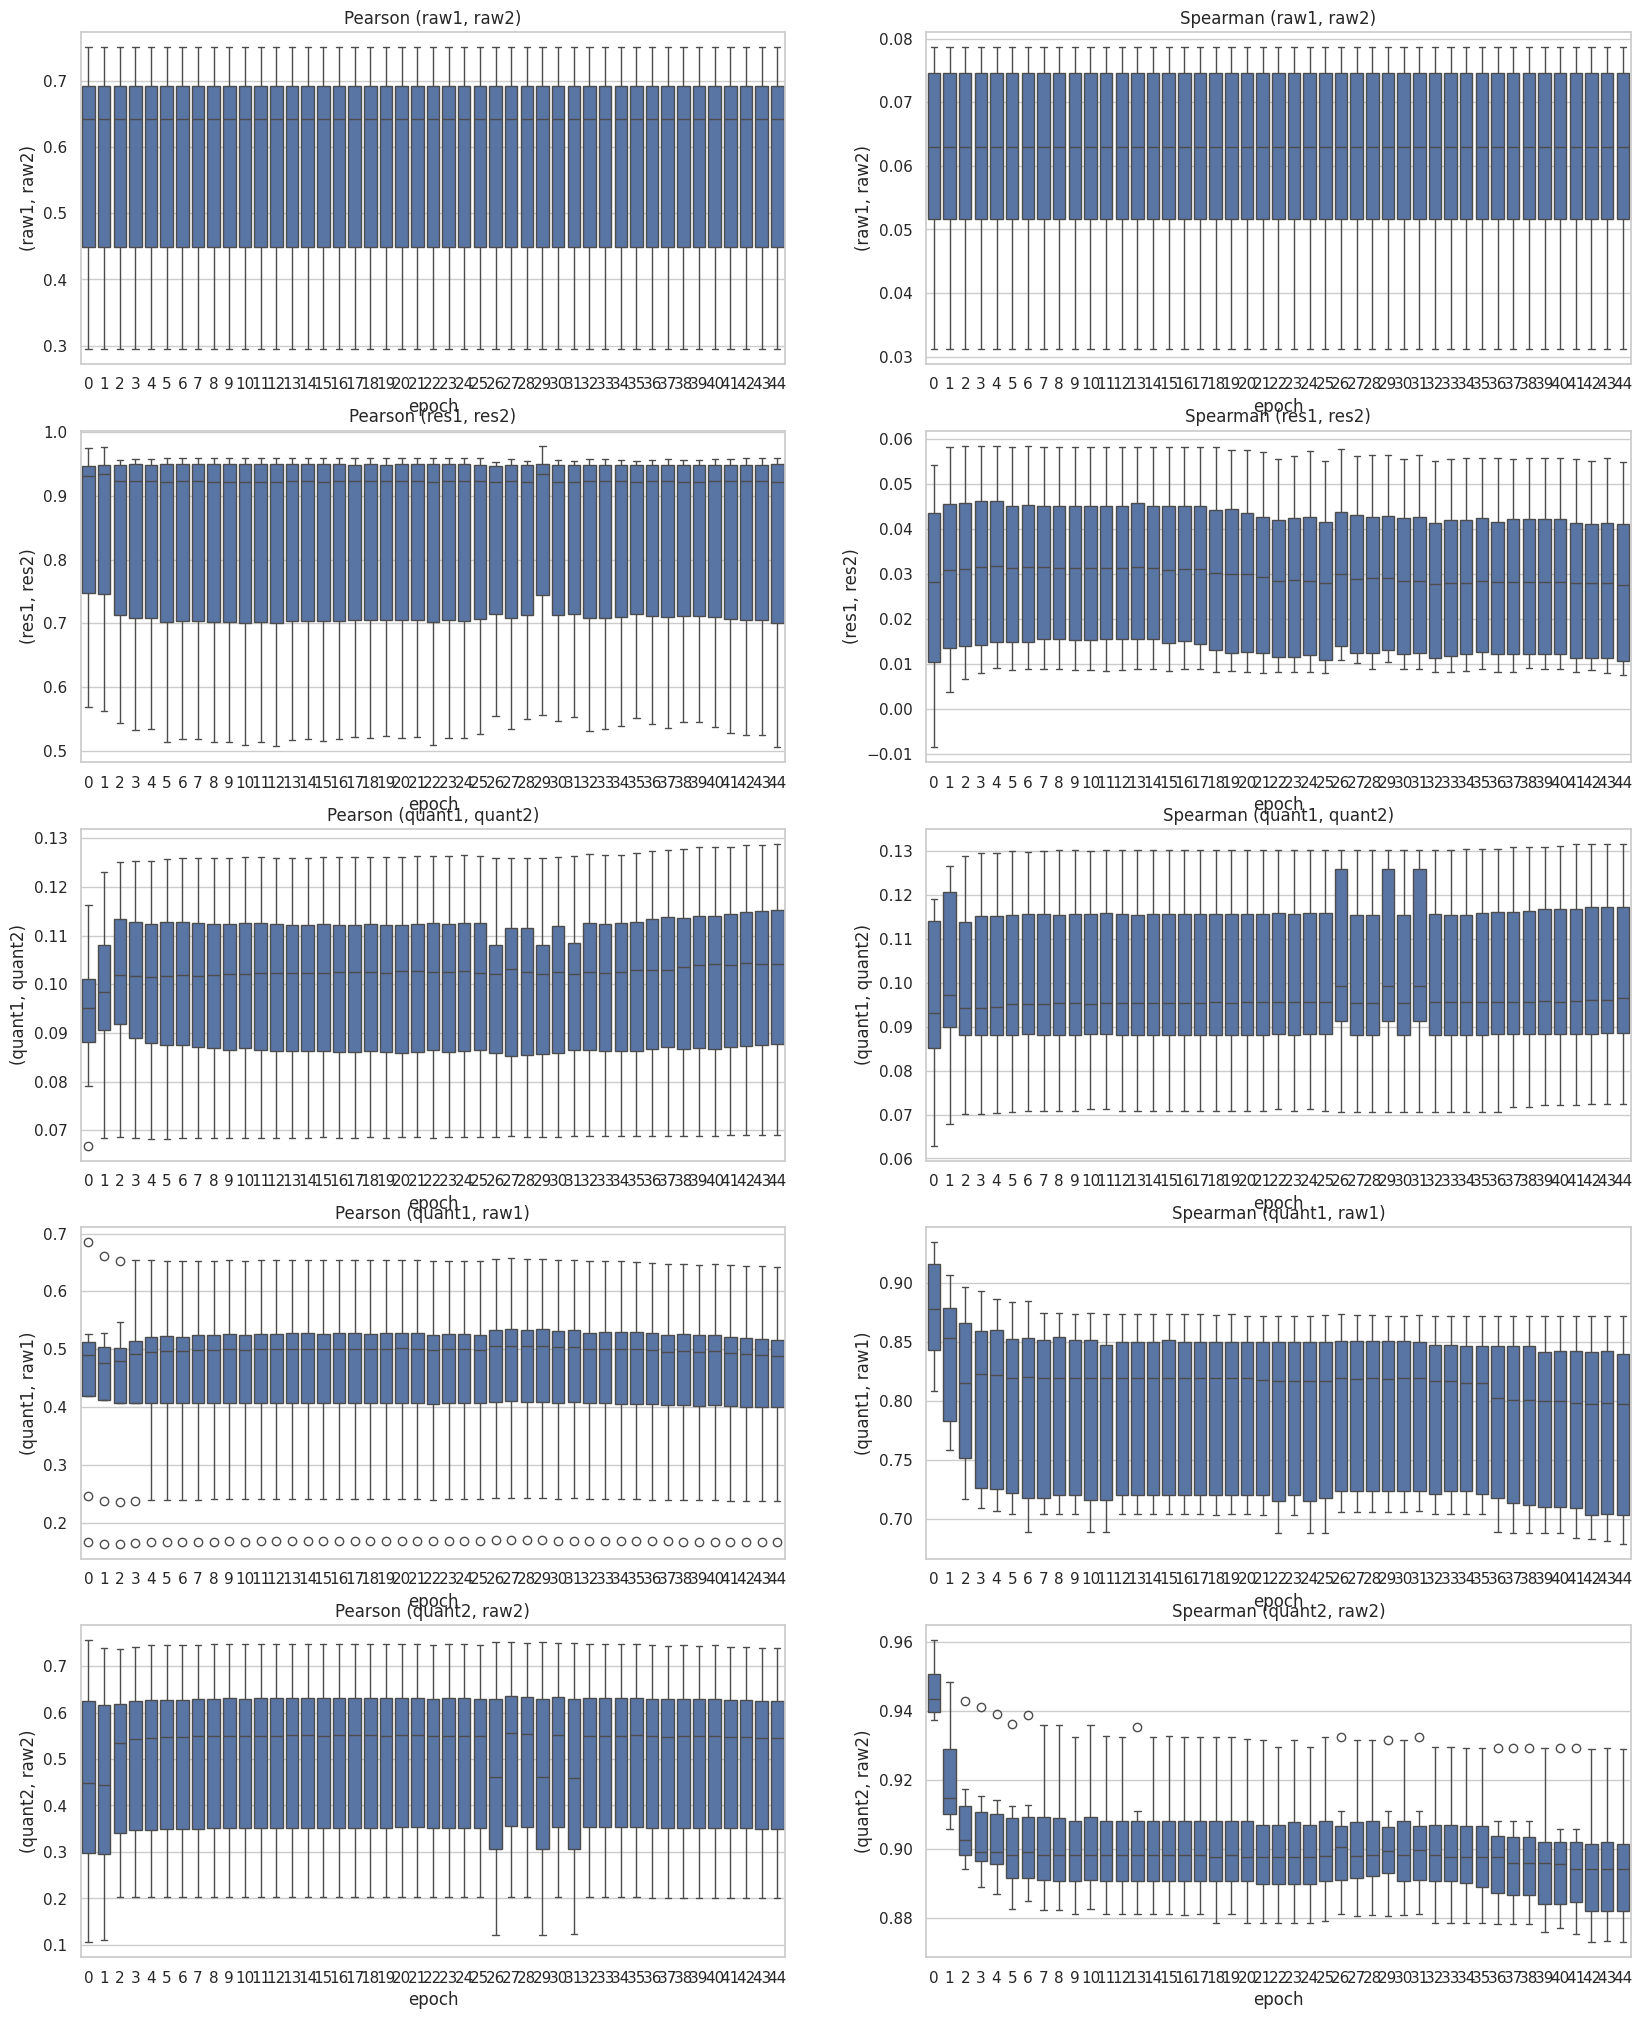

In [5]:
ctcf_dfs = run_analysis(Path("/lotterlab/users/abdul/repos/chipvi/runs/mu_r_ll_only/ctcf"))
ctcf_dfs[-1]